### LSUV - Layer-Wise Sequential Unit-Variance

In this notebook we explore the efficacy of weight initializations and implement the LSUV algorithm.
The effectiveness of LSUV is measured by the accuracy of the trained network after 3 epochs and other metrics on the activations.

*extracted and adapted from Fastai2023Part2 - building Miniai*

In [1]:
import sys, gc, traceback
import torch
import random
import numpy as np
from torch import nn, tensor, optim
from torch.nn import init
import matplotlib
import matplotlib.pyplot as plt

from operator import itemgetter
from functools import partial

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import default_collate

import torchvision.transforms.functional as TF

In [2]:
from datasets import load_dataset, load_dataset_builder

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
matplotlib.rcParams['image.cmap'] = 'gray'

In [4]:
def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
name = 'fashion_mnist'
ds_dict = load_dataset(name)

In [6]:
ds_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [7]:
train_ds, test_ds = ds_dict['train'], ds_dict['train']

In [8]:
def transform(b): 
    b['image'] = [TF.to_tensor(o) for o in b['image']]
    return b

In [9]:
train_ds, test_ds

(Dataset({
     features: ['image', 'label'],
     num_rows: 60000
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 60000
 }))

In [10]:
t_train_ds = train_ds.with_transform(transform)
t_test_ds = test_ds.with_transform(transform)

In [11]:
type(t_train_ds[0]['image']) , type(train_ds[0]['image'])  

(torch.Tensor, PIL.PngImagePlugin.PngImageFile)

In [12]:
bs = 256

The `DataLoader` class accepts dictionaries, so it is fine to directly feed it the huggingface train/test dicts: 

In [13]:
train_dl = DataLoader(t_train_ds, batch_size=bs, num_workers=4, pin_memory=True)
test_dl = DataLoader(t_test_ds, batch_size=bs, num_workers=4, pin_memory=True)

In [14]:
batch_ = next(iter(train_dl))
batch_['image'].shape, batch_['label']

(torch.Size([256, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5,
         9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1, 6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7,
         9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8, 8, 0, 1, 1, 6, 8, 1, 9, 7, 8, 8, 9, 6, 6, 3, 1, 5, 4, 6, 7, 5, 5, 9, 2, 2, 2, 7, 6, 4, 1, 8, 7,
         7, 5, 4, 2, 9, 1, 7, 4, 6, 9, 7, 1, 8, 7, 1, 2, 8, 0, 9, 1, 8, 7, 0, 5, 8, 6, 7, 2, 0, 8, 7, 1, 6, 2, 1, 9, 6, 0, 1, 0, 5, 5, 1, 7,
         0, 5, 8, 4, 0, 4, 0, 6, 6, 4, 0, 0, 4, 7, 3, 0, 5, 8, 4, 1, 1, 2, 9, 2, 8, 5, 0, 6, 3, 4, 6, 0, 9, 1, 7, 3, 8, 5, 8, 3, 8, 5, 2, 0,
         8, 7, 0, 3, 5, 0, 6, 5, 2, 7, 5, 2, 6, 8, 2, 6, 8, 0, 4, 4, 4, 4, 4, 1, 5, 6, 5, 3, 3, 7, 3, 3, 6, 2, 8, 4]))

We can also transform the dictionary into a tuple, the usual pytorch format:

In [15]:
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [16]:
train_dl = DataLoader(t_train_ds, batch_size=bs, collate_fn=collate_dict(t_train_ds), num_workers=4, pin_memory=True)
test_dl = DataLoader(t_test_ds, batch_size=bs, collate_fn=collate_dict(t_test_ds), num_workers=4, pin_memory=True)

In [17]:
xb, yb = next(iter(train_dl))
xb.shape, yb

(torch.Size([256, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5,
         9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1, 6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7,
         9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8, 8, 0, 1, 1, 6, 8, 1, 9, 7, 8, 8, 9, 6, 6, 3, 1, 5, 4, 6, 7, 5, 5, 9, 2, 2, 2, 7, 6, 4, 1, 8, 7,
         7, 5, 4, 2, 9, 1, 7, 4, 6, 9, 7, 1, 8, 7, 1, 2, 8, 0, 9, 1, 8, 7, 0, 5, 8, 6, 7, 2, 0, 8, 7, 1, 6, 2, 1, 9, 6, 0, 1, 0, 5, 5, 1, 7,
         0, 5, 8, 4, 0, 4, 0, 6, 6, 4, 0, 0, 4, 7, 3, 0, 5, 8, 4, 1, 1, 2, 9, 2, 8, 5, 0, 6, 3, 4, 6, 0, 9, 1, 7, 3, 8, 5, 8, 3, 8, 5, 2, 0,
         8, 7, 0, 3, 5, 0, 6, 5, 2, 7, 5, 2, 6, 8, 2, 6, 8, 0, 4, 4, 4, 4, 4, 1, 5, 6, 5, 3, 3, 7, 3, 3, 6, 2, 8, 4]))

To plot the image, we can use `plt.imshow` - we note that the colors will be inverted so as $img \in [0,1]$ a simple $(img-1)\times(-1)$ will give the right rendering:

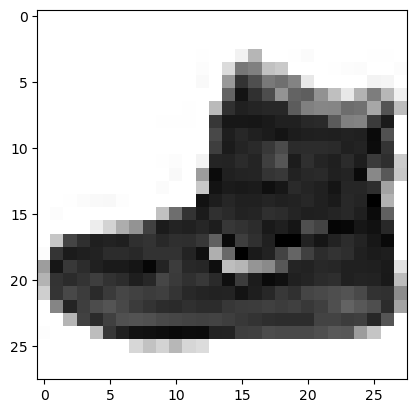

In [18]:
plt.imshow((xb[0].squeeze()-1)*-1);

We can now build a simple CNN model. The images are $28\times28$ so with a `stride` of 2 the images will shrink by a factor of 2 at each `Conv2d` layer, going from $28\times28$ to $14\times14$ to $7\times7$ to $4\times4$ to $2\times2$ to $1\times1$ in 5 `Conv2d` layers: 

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [21]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(device)

In [22]:
model = get_model()
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [23]:
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [24]:
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [25]:
def fit(epochs, model, loss_func, lr, opt_func, train_dl, valid_dl):
#     model.to(device)
    opt = opt_func(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

### Normal init 

In [26]:
set_seed(1)
model = get_model()

In [203]:
# act_means = [[] for m in model.modules() if isinstance(m, nn.Conv2d)]
# act_stds = [[] for m in model.modules() if isinstance(m, nn.Conv2d)]
# act_hists = [[] for m in model.modules() if isinstance(m, nn.Conv2d)]

In [42]:
def run(model, lr=0.1, layer_type=nn.Conv2d):
    set_seed(1)
    
    global act_means
    global act_stds
    global act_hists
    
    act_means = [[] for m in model.modules() if isinstance(m, layer_type)]
    act_stds = [[] for m in model.modules() if isinstance(m, layer_type)]
    act_hists = [[] for m in model.modules() if isinstance(m, layer_type)]
    hooks = []
    
    i=0
    for m in model.modules():
        if isinstance(m, layer_type): 
            hooks.append(m.register_forward_hook(partial(append_stats,i)))
            i += 1
    
    fit(3, model, F.cross_entropy, lr, optim.SGD, train_dl, test_dl)
    
    remove_hooks(hooks)
    
    plot_stats()
    color_dim()
    dead_chart()

In [28]:
def append_stats(i, model, inputs, outputs):
    act_means[i].append(outputs.detach().cpu().mean())
    act_stds[i].append(outputs.detach().cpu().std())
    act_hists[i].append(outputs.detach().cpu().abs().histc(40,0,10))

In [29]:
def remove_hooks(hook_list):
    for h in hook_list: h.remove()

In [30]:
def plot_stats():
    fig, axs = plt.subplots(1,2, figsize=(10,3))
    axs[0].set_title('means')
    axs[1].set_title('stds')
    for mean, std in zip(act_means[:-1], act_stds[:-1]): 
        axs[0].plot(mean)
        axs[1].plot(std)
    for ax in axs: ax.legend(range(5));

In [31]:
def get_hist(h): return torch.stack(h).t().float().log1p()

In [55]:
def color_dim():
    k = len(act_means)//2 if len(act_means)%2 == 0 else len(act_means)//2 + 1
    fig,axes = plt.subplots(k,2, figsize=(11,5))
    for i,(ax,h) in enumerate(zip(axes.flatten(), act_hists)):
        ax.set_title(f'Layer_{i}')
        ax.imshow(get_hist(h).numpy(), origin='lower', cmap='viridis', aspect=7)
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.axis('off')

In [56]:
def get_min(h):
    h1 = torch.stack(h).t().float()
    return h1[0]/h1.sum(0)

In [57]:
def dead_chart():
    k = len(act_means)//2 if len(act_means)%2 == 0 else len(act_means)//2 + 1
    fig,axes = plt.subplots(k,2, figsize=(11,5))
    for ax,h in zip(axes.flatten(), act_hists):
        ax.plot(get_min(h))
        ax.set_ylim(0,1)

In [212]:
set_seed(1)
model = get_model()

0 0.7165730694770813 0.74075
1 0.5184550535043081 0.8134166667302449
2 0.45835670873324075 0.8333833333651225


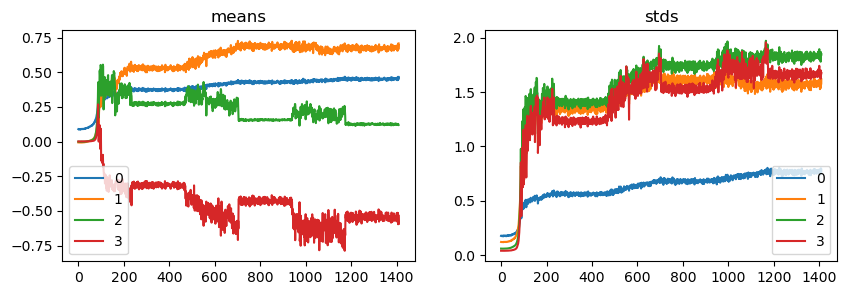

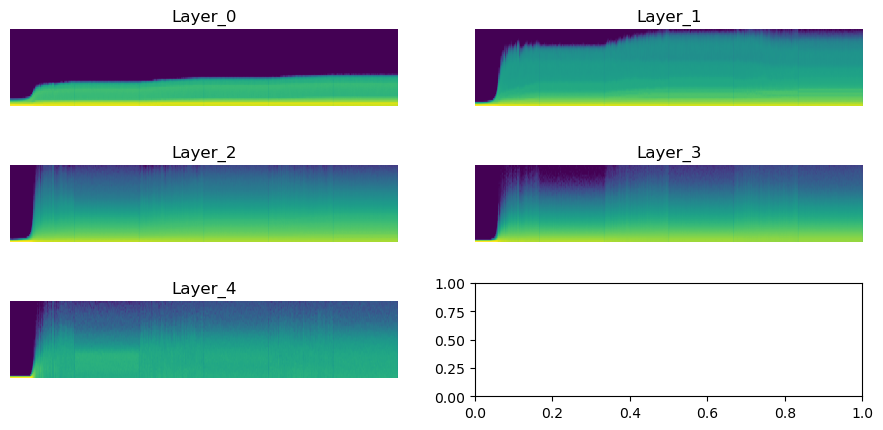

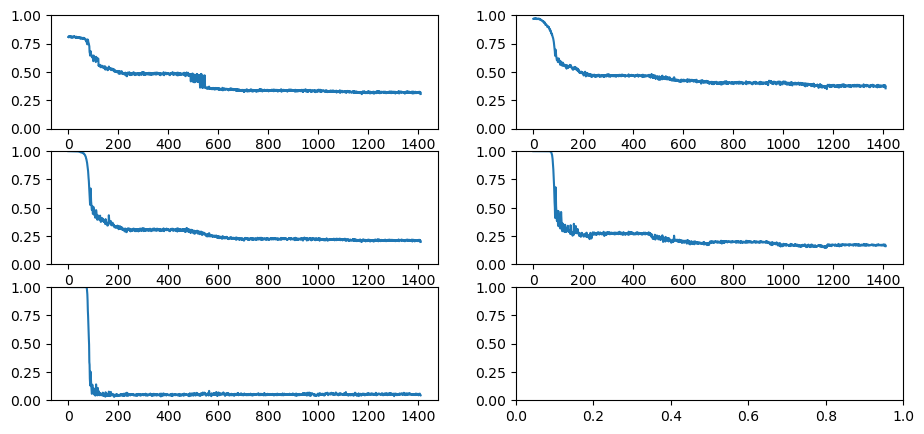

In [213]:
run(model, lr=0.2)

### Input Normalization

In [35]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.29), tensor(0.35))

In [36]:
def transform(b): 
    b['image'] = [(TF.to_tensor(o)-xmean)/xstd for o in b['image']]
    return b

In [37]:
t_train_ds = train_ds.with_transform(transform)
t_test_ds = test_ds.with_transform(transform)

In [38]:
train_dl = DataLoader(t_train_ds, batch_size=bs, collate_fn=collate_dict(t_train_ds), num_workers=4, pin_memory=True)
test_dl = DataLoader(t_test_ds, batch_size=bs, collate_fn=collate_dict(t_test_ds), num_workers=4, pin_memory=True)

In [39]:
xb, yb = next(iter(train_dl))
xb.mean(), xb.std()

(tensor(    -0.00), tensor(1.00))

In [40]:
set_seed(1)
model = get_model()

0 0.5907028452555338 0.7914166666666667
1 0.4686508408387502 0.8322333333333334
2 0.40049030085404713 0.8551833333333333


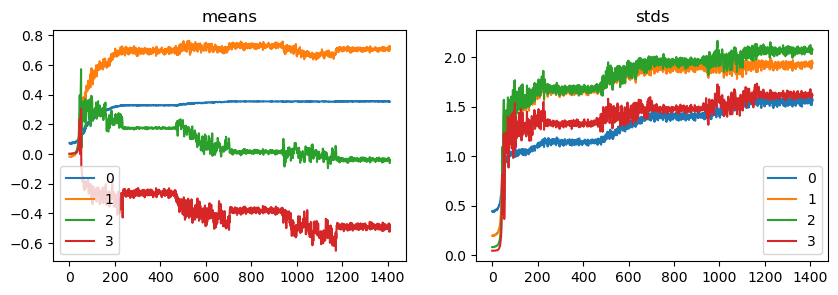

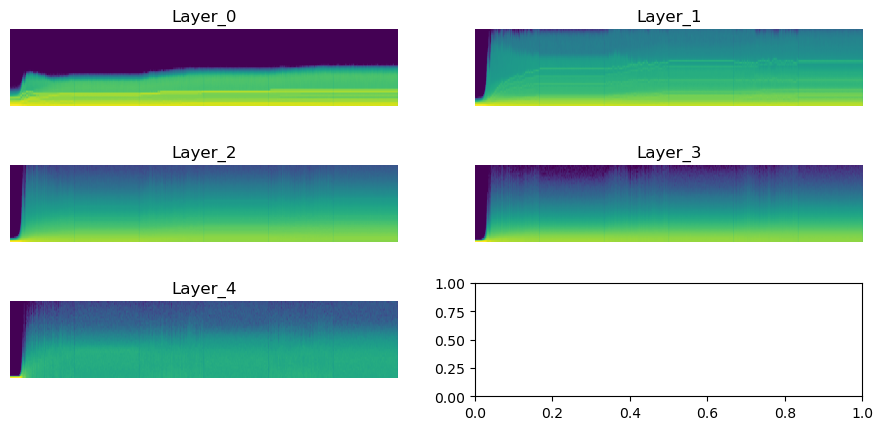

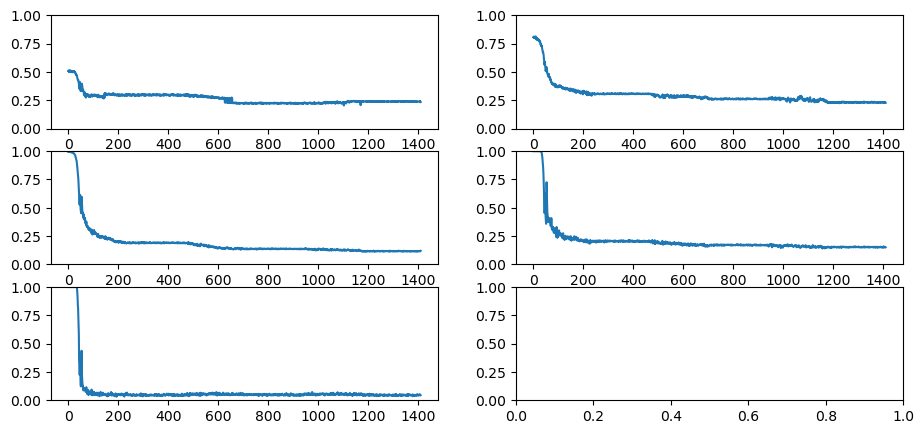

In [41]:
run(model, lr=0.2)

### Kaiming init

In [43]:
def init_weights(m, leaky=0):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

In [223]:
set_seed(1)
model = get_model().apply(init_weights)

0 0.4522270388841629 0.8334833333969116
1 0.3862883079449336 0.8587500000635783
2 0.3576120318333308 0.8703833333333333


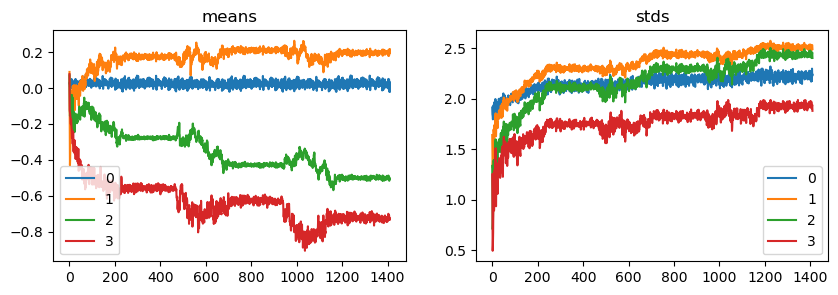

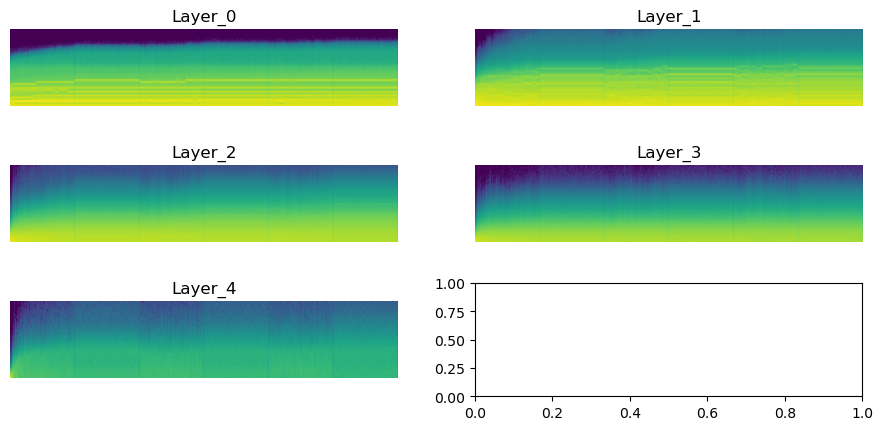

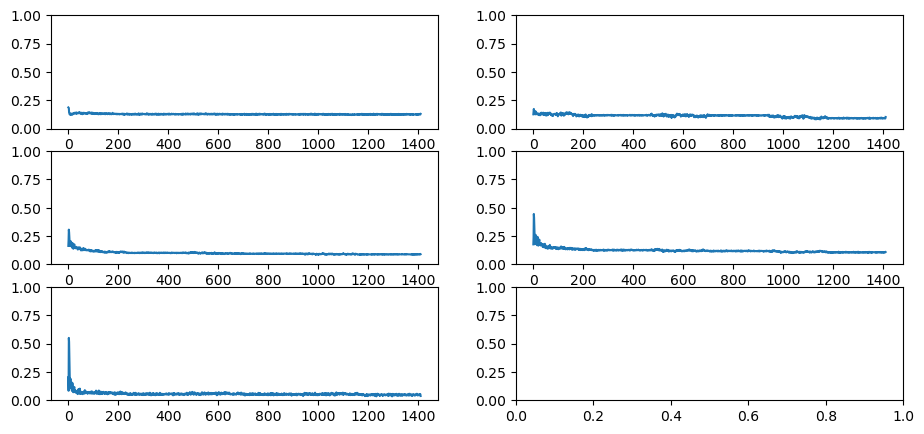

In [224]:
run(model, lr=0.2)

### General ReLU

Trying to optimize the weights with GeneralRelu:

In [47]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [48]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [49]:
set_seed(1)
model = get_model(act_gr).apply(iw)

0 0.4860240015188853 0.8285833333969116
1 0.37894635757605233 0.8621833333651224
2 0.3325243157784144 0.8780166667302449


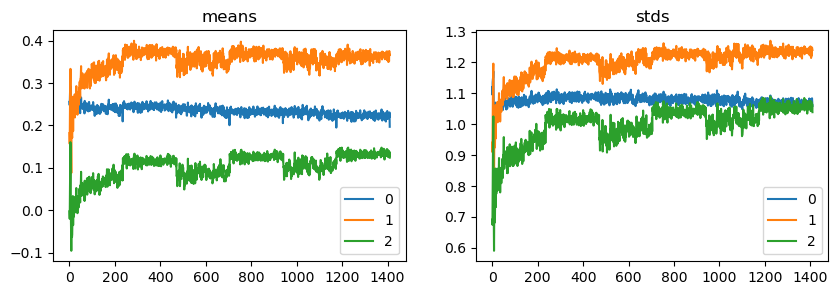

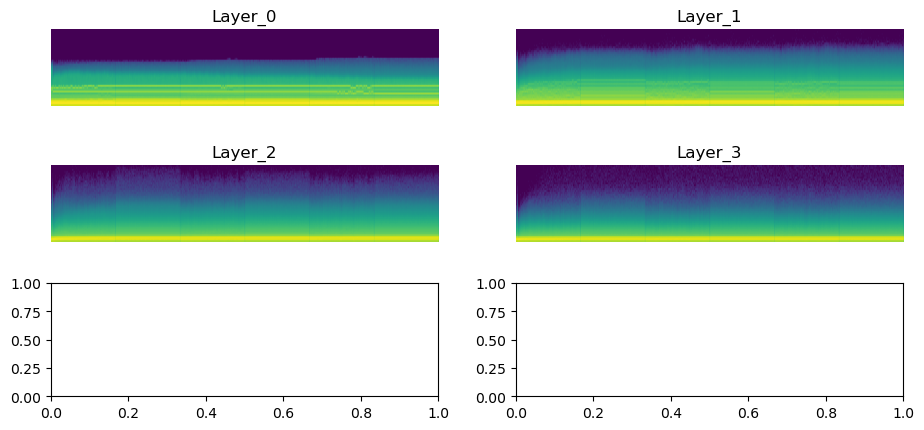

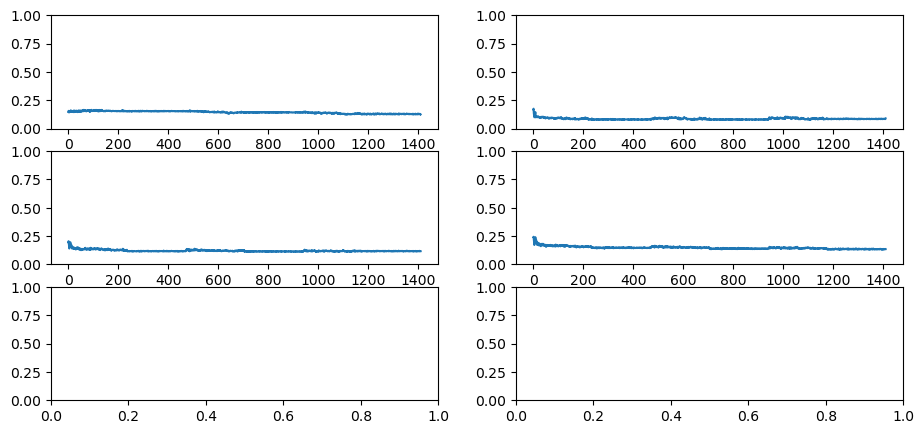

In [51]:
run(model, lr=0.2, layer_type=GeneralRelu)

### LSUV - Layer-Wise Sequential Unit-Variance

In [44]:
class Hook():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self))
        self.mod_nm = type(m).__name__
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [45]:
def _lsuv_stats(hook, mod, inp, outp):
    acts = outp.detach().cpu()
    hook.mean = acts.mean()
    hook.std = acts.std()

In [46]:
def lsuv_init(m, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
#         while model(xb) is not None and (abs(h.std**2-1)>1e-3 or abs(h.mean)>1e-3):
        while model(xb) is not None and abs(h.std**2-1)>1e-3:
            print('before', h.mean, h.std)
            m.bias -= h.mean
            m.weight.data /= h.std
        print('after', h.mean, h.std)
    print()
    h.remove()

Here we perform the adjusment on the outputs of the `Conv2d` layers.

In [227]:
set_seed(1)
model = get_model()
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]
for m in convs: lsuv_init(m, xb.to(device))

before tensor(0.07) tensor(0.44)
before tensor(0.01) tensor(0.95)
before tensor(0.00) tensor(1.00)
after tensor(    0.00) tensor(1.00)

before tensor(-0.05) tensor(0.39)
before tensor(-0.06) tensor(0.99)
after tensor(-0.00) tensor(1.00)

before tensor(0.01) tensor(0.37)
before tensor(0.02) tensor(0.99)
after tensor(0.00) tensor(1.00)

before tensor(0.01) tensor(0.35)
before tensor(0.01) tensor(1.00)
after tensor(    0.00) tensor(1.00)

before tensor(0.01) tensor(0.20)
before tensor(0.09) tensor(0.99)
after tensor(0.00) tensor(1.00)



0 0.4372187452872594 0.8436333333651225
1 0.3565664598226547 0.8711666666984558
2 0.3254535896062851 0.8820000000635783


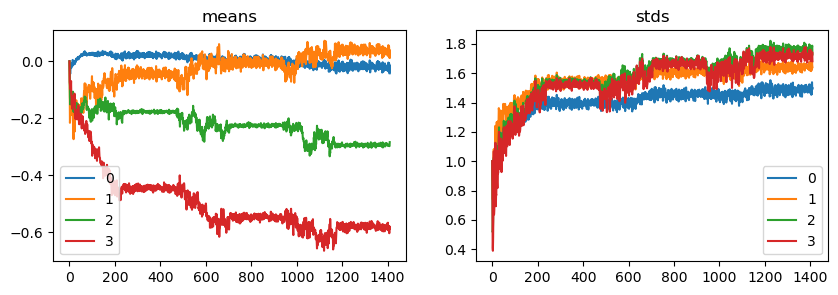

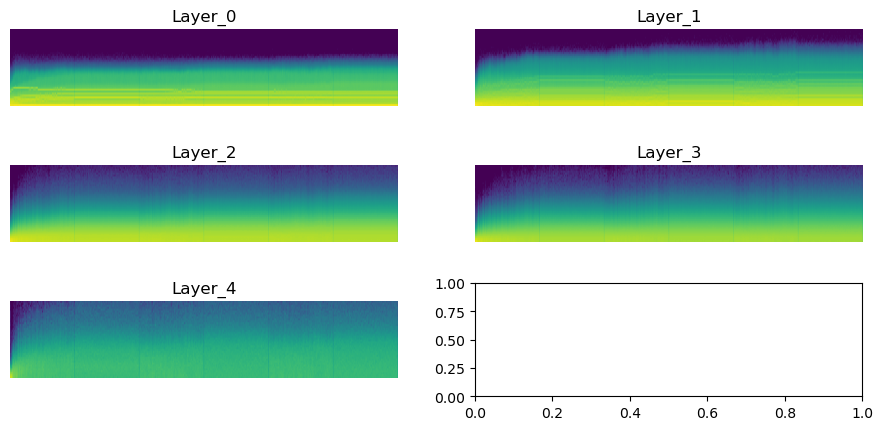

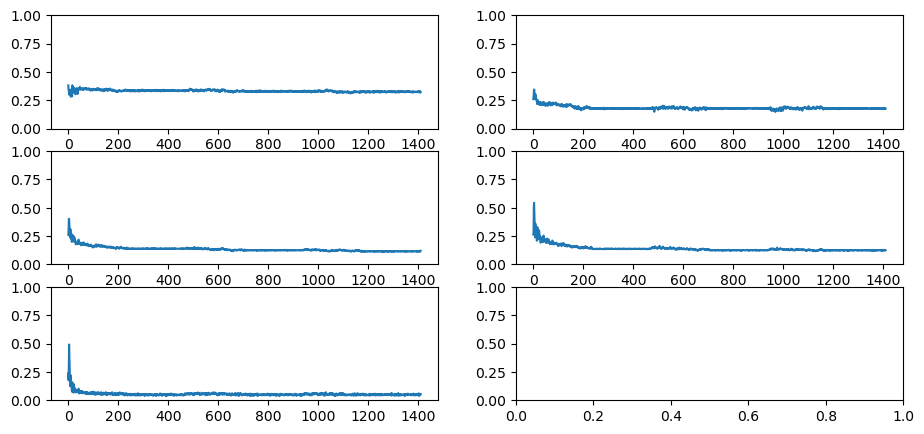

In [228]:
run(model, lr=0.2)

**LSUV and GeneralReLU:**

In [52]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [53]:
set_seed(1)
model = get_model(act_gr).apply(iw)
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]
for m in convs: lsuv_init(m, xb.to(device))

before tensor(0.03) tensor(1.90)
before tensor(0.02) tensor(1.01)
after tensor(0.00) tensor(1.00)

before tensor(0.09) tensor(0.74)
before tensor(0.03) tensor(1.00)
after tensor(-0.00) tensor(1.00)

before tensor(0.06) tensor(0.70)
after tensor(0.03) tensor(1.00)

before tensor(-0.01) tensor(0.75)
before tensor(-0.00) tensor(1.00)
after tensor(    -0.00) tensor(1.00)

before tensor(-0.16) tensor(0.58)
before tensor(-0.11) tensor(1.00)
after tensor(-0.00) tensor(1.00)



0 0.44523298817475637 0.838466666730245
1 0.3830860320965449 0.8590500000635782
2 0.3495739466746648 0.8702500000635783


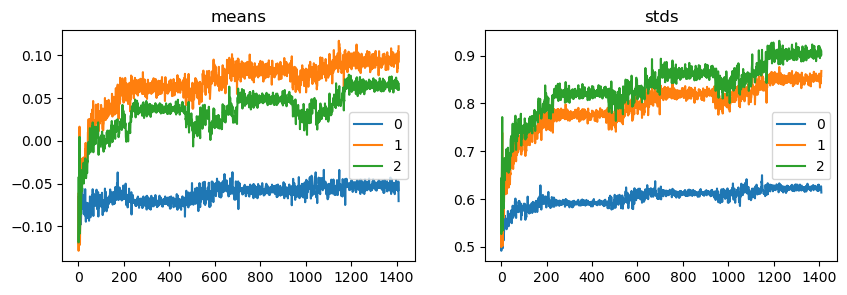

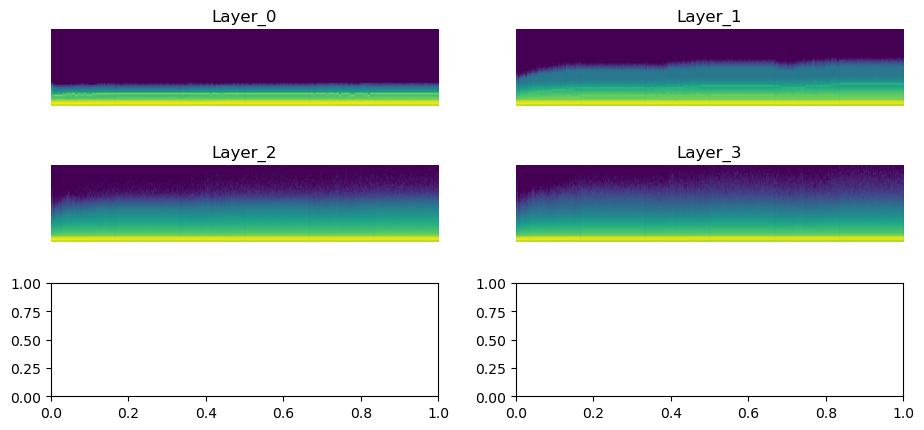

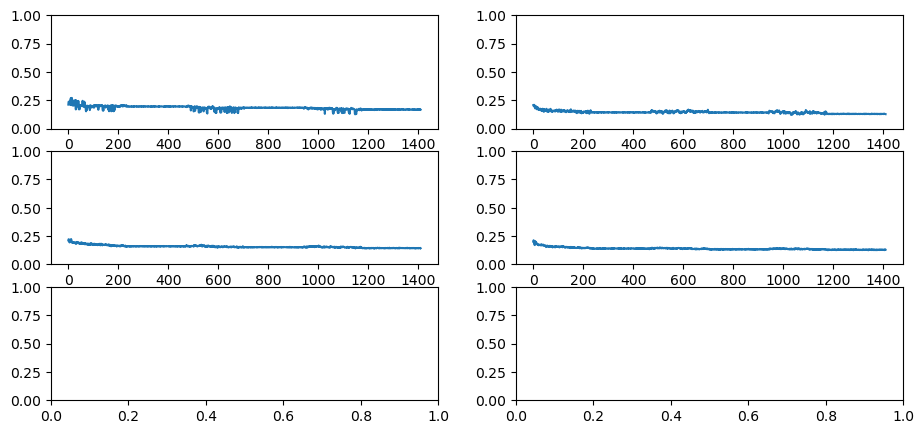

In [54]:
run(model, lr=0.2, layer_type=GeneralRelu)

**LSUV modifying the `Conv2d` layers so the output of `GeneraRelu` gives a mean 0 variance 1** 

In [60]:
def lsuv_init(m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std**2-1)>1e-3 or abs(h.mean)>1e-3):
#         while model(xb) is not None and abs(h.std**2-1)>1e-3:
            print('before', h.mean, h.std)
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
        print('after', h.mean, h.std)
    print()
    h.remove()

In [62]:
set_seed(1)
model = get_model(act_gr).apply(iw)
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
for ms in zip(relus, convs): lsuv_init(*ms, xb.to(device))

before tensor(0.26) tensor(1.12)
before tensor(0.05) tensor(0.93)
before tensor(0.07) tensor(0.99)
before tensor(0.04) tensor(0.98)
before tensor(0.03) tensor(0.99)
before tensor(0.03) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
after tensor(0.00) tensor(1.00)

before tensor(0.13) tensor(0.84)
before tensor(0.15) tensor(0.97)
before tensor(0.08) tensor(0.96)
before tensor(0.07) tensor(0.98)
before tensor(0.04) tensor(0.98)
before tensor(0.03) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before ten

0 0.47980526668230694 0.8257
1 0.3957940753698349 0.8559833333969116
2 0.3451091584444046 0.8717833333651225


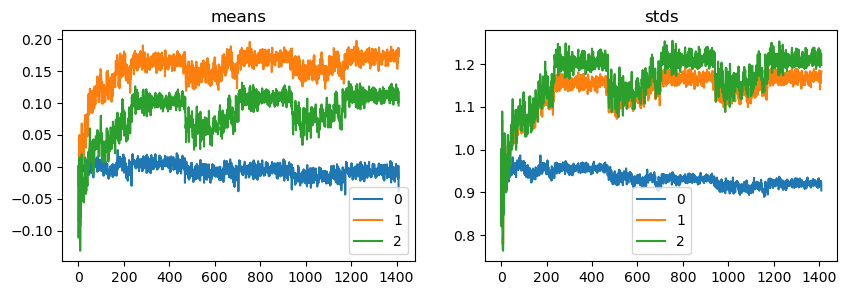

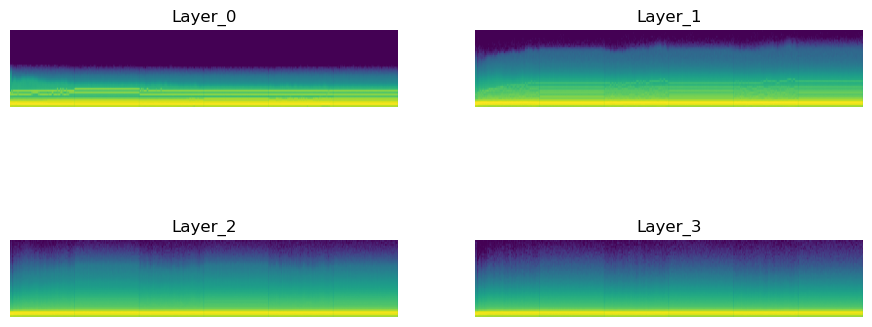

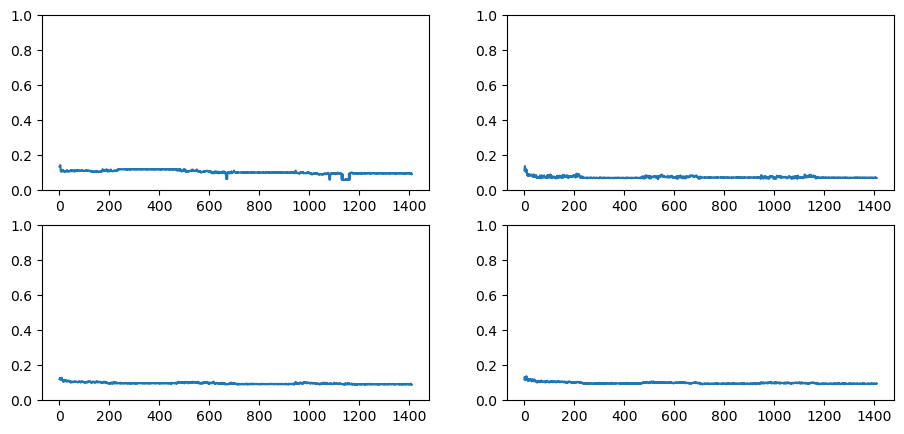

In [63]:
run(model, lr=0.2, layer_type=GeneralRelu)